# Loading data and Libraries

In [2]:
# Basic
import seaborn as sns
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import STL

# Models
from xgboost import XGBRegressor
from xgboost import plot_importance
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#Extras
from itertools import product
import time
import sys
import gc
import pickle
import warnings
sys.version_info
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

In [3]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [4]:
DATA_PATH = r'data/'

In [5]:
item=pd.read_csv(DATA_PATH+'items.csv')

In [6]:
item_categories=pd.read_csv(DATA_PATH+'item_categories.csv')

In [7]:
sales_train=pd.read_csv(DATA_PATH+'sales_train.csv')

In [8]:
shops=pd.read_csv(DATA_PATH+'shops.csv')

In [9]:
test=pd.read_csv(DATA_PATH+'test.csv')

# EDA

In [10]:
sales_train_merge = pd.merge(sales_train,item,how='left',on='item_id').drop('item_name',axis=1)

In [11]:
sales_monthly = sales_train.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [12]:
print("----------Top-5- Record----------")
print(sales_train_merge.head(5))
print("-----------Information-----------")
print(sales_train_merge.info())
print("-----------Data Types-----------")
print(sales_train_merge.dtypes)
print("----------Missing value-----------")
print(sales_train_merge.isnull().sum())
print("----------Null value-----------")
print(sales_train_merge.isna().sum())
print("----------Shape of Data----------")
print(sales_train_merge.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

   item_category_id  
0                37  
1                58  
2                58  
3                58  
4                56  
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   ite

In [13]:
## Almost 7200 item_cnt_day with -1 , probably was NaN, remove?
sales_train[sales_train['item_cnt_day']==-1]['shop_id'].value_counts()[:5]  ##7200

31    449
12    391
54    353
25    315
57    311
Name: shop_id, dtype: int64

In [14]:
itens = pd.DataFrame(item.groupby('item_category_id')['item_id'].count())
itens_sort = itens.sort_values(by='item_id',ascending=False)[:12]

In [15]:
itens_train = pd.DataFrame(sales_train_merge.groupby('item_category_id')['item_id'].count())
itens_sort_train = itens_train.sort_values(by='item_id',ascending=False)[:12]

In [16]:
sales_test = pd.merge(test,item,how='left',on='item_id').drop('item_name',axis=1)
itens_test = pd.DataFrame(sales_test.groupby('item_category_id')['item_id'].count())
itens_sort_test = itens_test.sort_values(by='item_id',ascending=False)[:12]

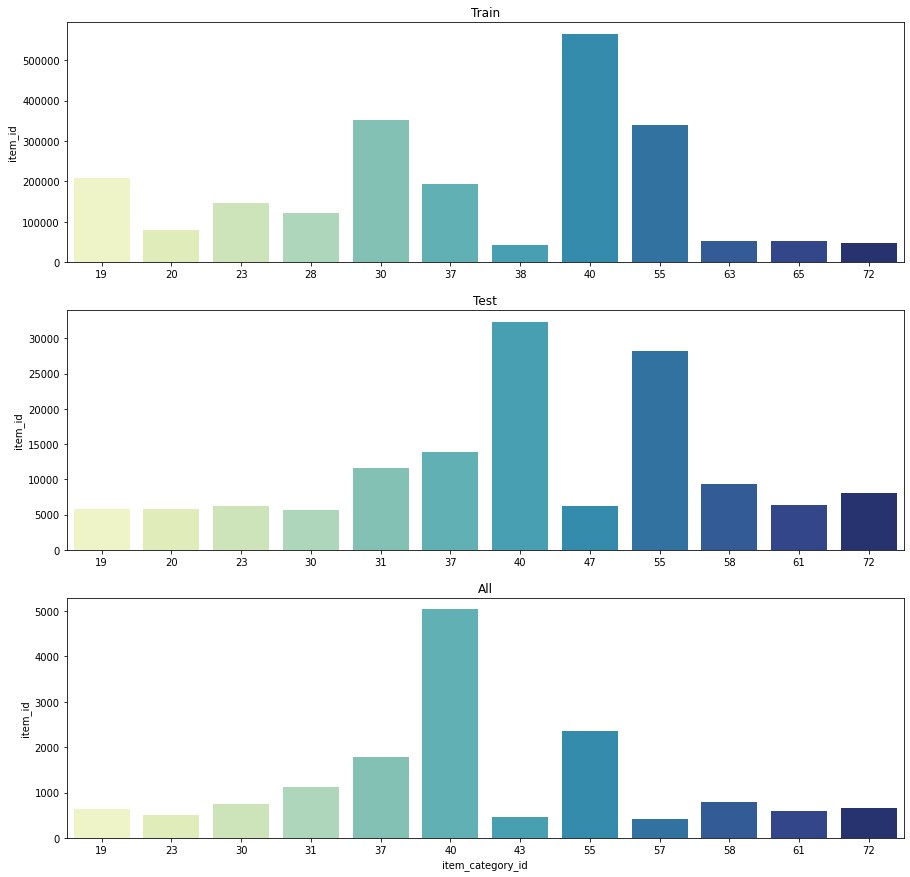

In [17]:
## Itens per category, compare with total, train, test
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
sns.barplot(x=itens_sort_train.index,y=itens_sort_train['item_id'],palette='YlGnBu')
plt.title('Train')
plt.xlabel('')
plt.subplot(3,1,2)
sns.barplot(x=itens_sort_test.index,y=itens_sort_test['item_id'],palette='YlGnBu')
plt.title('Test')
plt.xlabel('')
plt.subplot(3,1,3)
sns.barplot(x=itens_sort.index,y=itens_sort['item_id'],palette='YlGnBu')
plt.title('All')
plt.show()

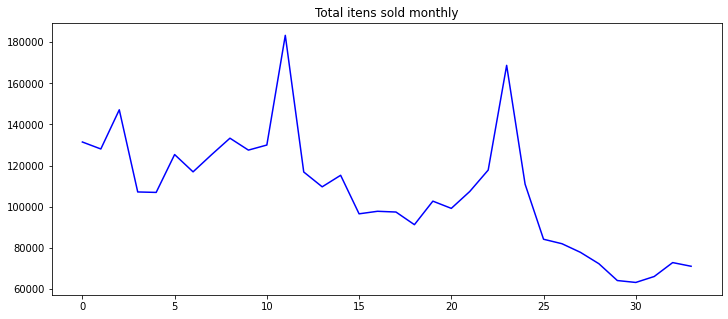

In [18]:
item_sum = pd.DataFrame(sales_train_merge.groupby('date_block_num')['item_cnt_day'].sum())
plt.figure(figsize=(12,5))
plt.plot(item_sum,color='Blue')
plt.title('Total itens sold monthly')
plt.show()

## Using prophet

In [22]:
item_sum = sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()

<Figure size 216x360 with 0 Axes>

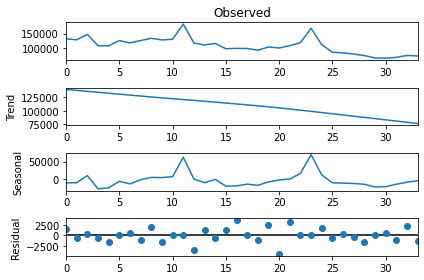

In [23]:
plt.figure(figsize=(3,5))
res = STL(item_sum.values,period=12).fit()
fig = res.plot()
plt.show()

In [24]:
# Stationarity tests

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)# TIME SERIES


test_stationarity(item_sum)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [25]:
# adding the dates to the Time-series as index
baseline = sales_train_merge.groupby(["date_block_num"])["item_cnt_day"].sum()
baseline.index = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
baseline = baseline.reset_index()
baseline.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [26]:
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
baseline.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(baseline) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957369,80136.444874,86248.203500
35,2015-12-01,125513.063131,122386.741038,128663.336672
36,2016-01-01,75625.688684,72448.837892,78755.756292
37,2016-02-01,40109.144589,37017.403573,43172.645886
38,2016-03-01,76664.084864,73285.428507,79788.601640


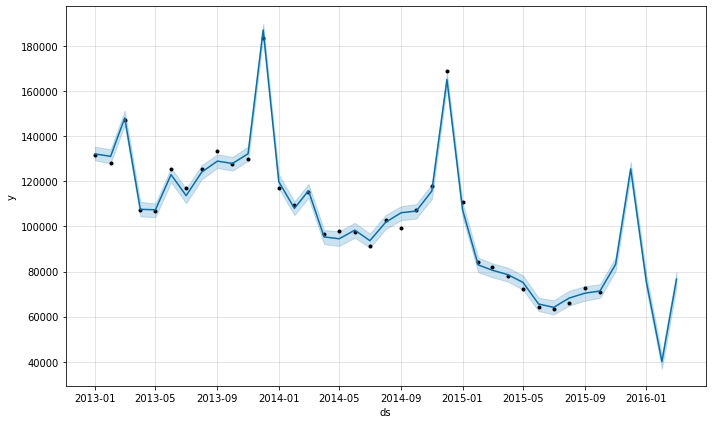

In [28]:
model.plot(forecast)
plt.show()

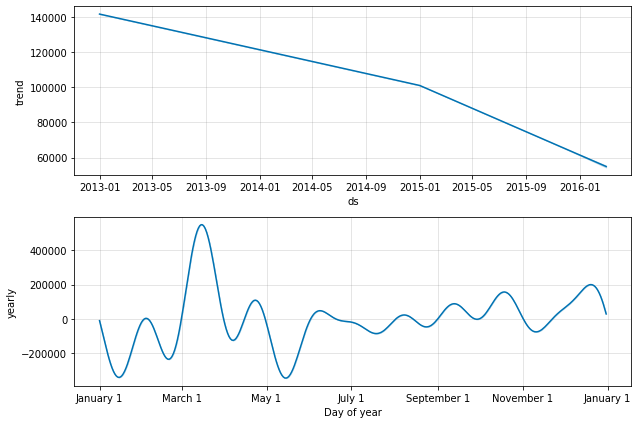

In [29]:
model.plot_components(forecast)
plt.show()

## Feature Engineering

In [30]:
sales_train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [31]:
sales_monthly.head()

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013      221.0          6.0
                       33       03.01.2013  28.01.2013      347.0          3.0
                       35       31.01.2013  31.01.2013      247.0          1.0
                       43       31.01.2013  31.01.2013      221.0          1.0
                       51       13.01.2013  31.01.2013      128.5          2.0

### Outliers

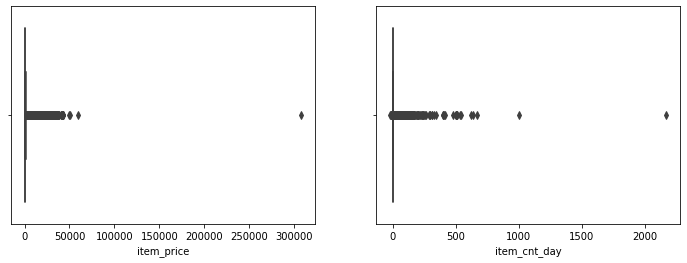

In [32]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(sales_train_merge['item_price'])
plt.subplot(1,2,2)
sns.boxplot(sales_train_merge['item_cnt_day'])
plt.show()

In [33]:
## Removing outliers from item_price
## Negative values and values larger then 50000
sales_train_merge_new = sales_train_merge[(sales_train_merge['item_price'] > 0) & (sales_train_merge['item_price'] < 80000)]

In [34]:
## Removing outliers from item_count
## Negative values and values larger then 200
sales_train_merge_new = sales_train_merge_new[(sales_train_merge_new['item_cnt_day'] > 0) & (sales_train_merge_new['item_cnt_day'] < 125)]

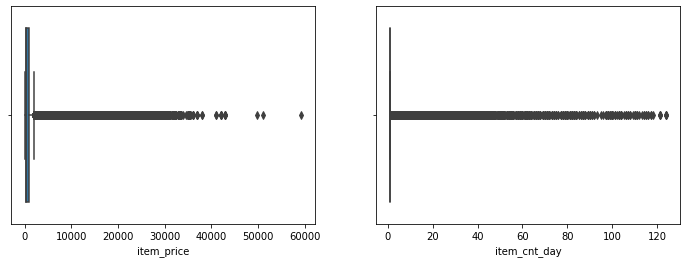

In [35]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(sales_train_merge_new['item_price'])
plt.subplot(1,2,2)
sns.boxplot(sales_train_merge_new['item_cnt_day'])
plt.show()

In [36]:
## Duplicate shops 

sales_train_merge_new.loc[sales_train_merge_new.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

sales_train_merge_new.loc[sales_train_merge_new.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

sales_train_merge_new.loc[sales_train_merge_new.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [37]:
## Only use shops and itens that appear in the test set

test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

sales_train_new = sales_train_merge_new[sales_train_merge_new['shop_id'].isin(test_shop_ids)]
sales_train_new = sales_train_new[sales_train_new['item_id'].isin(test_item_ids)]

In [38]:
sales_train_new.shape

(1224802, 7)

In [39]:
sales_train_new.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
10,03.01.2013,0,25,2574,399.0,2.0,55
11,05.01.2013,0,25,2574,399.0,1.0,55
12,07.01.2013,0,25,2574,399.0,1.0,55
13,08.01.2013,0,25,2574,399.0,2.0,55


In [40]:
sales_train_new['item_id'].nunique()*sales_train_new['shop_id'].nunique()

198072

In [41]:
test['shop_id'].nunique()*test['item_id'].nunique()

214200

In [42]:
sales_train_new = sales_train_new.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'] 
                                                               ,as_index=False).agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
sales_train_new.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [43]:
sales_train_new.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.0,1532.857143,9.0,1.285714,7
1,0,2,2,5643,2390.0,2390.000000,1.0,1.000000,1
2,0,2,5,5583,1188.3,594.150000,2.0,1.000000,2
3,0,2,6,7893,5970.0,1990.000000,3.0,1.000000,3
4,0,2,6,7894,1490.0,1490.000000,1.0,1.000000,1


In [44]:
sales_train_new['item_cnt_month'] = sales_train_new.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)


In [45]:
sales_train_new.shape

(601498, 10)

In [46]:
shop_ids = sales_train_new['shop_id'].unique()
item_ids = sales_train_new['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

sales_train_new = pd.merge(empty_df, sales_train_new, on=['date_block_num','shop_id','item_id'], how='left')
sales_train_new.fillna(0, inplace=True)

In [47]:
## Creating my label
sales_train_new['item_cnt_next'] = sales_train_new.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [48]:
sales_train_new.shape

(6734448, 11)

In [49]:
sales_train_new.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_month,item_cnt_next
0,0,2,5572,2.0,10730.0,1532.857143,9.0,1.285714,7.0,1.0,1.0
1,0,2,5643,2.0,2390.0,2390.000000,1.0,1.000000,1.0,5.0,0.0
2,0,2,5583,5.0,1188.3,594.150000,2.0,1.000000,2.0,1.0,1.0
3,0,2,7893,6.0,5970.0,1990.000000,3.0,1.000000,3.0,2.0,2.0
4,0,2,7894,6.0,1490.0,1490.000000,1.0,1.000000,1.0,2.0,2.0


In [50]:
# Extract time based features.
sales_train_new['year'] = sales_train_new['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_train_new['month'] = sales_train_new['date_block_num'].apply(lambda x: (x % 12))

In [51]:
## Unitary

sales_train_new['item_price_unit'] = sales_train_new['item_price'] // sales_train_new['item_cnt']
sales_train_new['item_price_unit'].fillna(0, inplace=True)

In [52]:
## group based



gp_item_price = sales_train_new.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

sales_train_new = pd.merge(sales_train_new, gp_item_price, on='item_id', how='left')

In [53]:
## How much the price changed

sales_train_new['price_increase'] = sales_train_new['item_price'] - sales_train_new['hist_min_item_price']
sales_train_new['price_decrease'] = sales_train_new['hist_max_item_price'] - sales_train_new['item_price']

In [ ]:


# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    sales_train_new[('item_cnt_%s' % function_name[i])] = sales_train_new.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
sales_train_new['item_cnt_std'].fillna(0, inplace=True)



In [ ]:

lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    sales_train_new[ft_name] = sales_train_new.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    sales_train_new[ft_name].fillna(0, inplace=True)



In [ ]:
sales_train_new['item_trend'] = sales_train_new['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    sales_train_new['item_trend'] -= sales_train_new[ft_name]

sales_train_new['item_trend'] /= len(lag_list) + 1

## Model

**Split**

In [52]:
train_set = sales_train_new.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = sales_train_new.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = sales_train_new.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/sales_train_new.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/sales_train_new.shape[0])*100)))

Train set records: 4951800
Validation set records: 990360
Test set records: 198072
Train set records: 4951800 (74% of complete data)
Validation set records: 990360 (15% of complete data)


**Mean Enconding**

In [53]:
train_set.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_month,item_cnt_next,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
594216,3,2,5572,2.0,2980.0,1490.0,2.0,1.0,2.0,2.0,2.0,2013,3,1490.0,0.0,18979.5,2980.0,15999.5,1.0,2.0,1.333333,0.577350,1.0,1.0,9.0,-2.25
594217,3,2,5643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2013,3,0.0,0.0,35260.0,0.0,35260.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00
594218,3,2,5583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,5592.0,0.0,5592.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00
594219,3,2,7893,6.0,9350.0,1870.0,5.0,1.0,5.0,1.0,1.0,2013,3,1870.0,0.0,42630.0,9350.0,33280.0,1.0,5.0,2.666667,2.081666,1.0,2.0,3.0,-0.25
594220,3,2,7894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,31290.0,0.0,31290.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00


In [54]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [55]:
train_set.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_month,item_cnt_next,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,3,2,5572,2.0,2980.0,1490.0,2.0,1.0,2.0,2.0,2.0,2013,3,1490.0,0.0,18979.5,2980.0,15999.5,1.0,2.0,1.333333,0.577350,1.0,1.0,9.0,-2.25,0.096938,1.002857,0.84,0.170795,0.159275
1,3,2,5643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2013,3,0.0,0.0,35260.0,0.0,35260.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,1.851429,1.64,0.170795,0.159275
2,3,2,5583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,5592.0,0.0,5592.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,0.572381,0.08,0.170795,0.159275
3,3,2,7893,6.0,9350.0,1870.0,5.0,1.0,5.0,1.0,1.0,2013,3,1870.0,0.0,42630.0,9350.0,33280.0,1.0,5.0,2.666667,2.081666,1.0,2.0,3.0,-0.25,0.096938,3.241905,3.28,0.170795,0.159275
4,3,2,7894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,31290.0,0.0,31290.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,3.915238,1.68,0.170795,0.159275


In [56]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [57]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

**Build test set**

In [59]:
train_set.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,item_cnt_month,item_cnt_next,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,3,2,5572,2.0,2980.0,1490.0,2.0,1.0,2.0,2.0,2.0,2013,3,1490.0,0.0,18979.5,2980.0,15999.5,1.0,2.0,1.333333,0.577350,1.0,1.0,9.0,-2.25,0.096938,1.002857,0.84,0.170795,0.159275
1,3,2,5643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2013,3,0.0,0.0,35260.0,0.0,35260.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,1.851429,1.64,0.170795,0.159275
2,3,2,5583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,5592.0,0.0,5592.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,0.572381,0.08,0.170795,0.159275
3,3,2,7893,6.0,9350.0,1870.0,5.0,1.0,5.0,1.0,1.0,2013,3,1870.0,0.0,42630.0,9350.0,33280.0,1.0,5.0,2.666667,2.081666,1.0,2.0,3.0,-0.25,0.096938,3.241905,3.28,0.170795,0.159275
4,3,2,7894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,0.0,31290.0,0.0,31290.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.096938,3.915238,1.68,0.170795,0.159275


In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

**Replace missing values with the median of each shop.**

In [28]:
sets = [X_train, X_validation, X_test] 
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

**Dropping item_category because test have differente itens**

In [29]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### **Catboost**

In [1]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
print('Model params:', catboost_model.get_params())

In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

### **XGBoost**

In [ ]:
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

### **Random forest**

In [ ]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

In [ ]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

### **Linear Regression**

In [ ]:
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

**Normalizing features**

In [ ]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [ ]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

In [ ]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

### **KNN Regressor**

In [ ]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

**Normalizing features**

In [ ]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

In [ ]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

### **Stacking**

In [ ]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

**Simple LinearRegression as Meta-model for our emsemble stacking**

In [ ]:
meta_model = LinearRegression(n_jobs=-1)

**Trained on validation set using the 1st level models predictions as features.**

In [ ]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

**Make predictions on test set using the 1st level models predictions as features.**

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

**Ensemble model metrics on validation set.**

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

In [ ]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')